# Librerías

In [440]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import tensorflow as tf
import seaborn as sns
import torch
import json
from PIL import Image
from torch import nn, optim
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Análisis Exploratorio

In [443]:
# Carga de los datos, se muestra la cantidad de muestras y clases dentro del dataset
df_train_sol = pd.read_csv('training_solutions_rev1.csv')
print('Shape: ', df_train_sol.shape)

Shape:  (61578, 38)


El dataset contiene los identificadores de cada imagen de galaxia y la probabilidad de cada clase.

In [445]:
df_train_sol.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [446]:
# Las columnas y clases disponibles para trabajar
df_train_sol.columns

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')

In [447]:
# Save a copy of all clases
df_all = df_train_sol.copy()

In [448]:
# Crear el dataframe para el primer y segundo nivel de arbol de decision (Galaxy Zoo)
df_train_sol = df_train_sol[['GalaxyID','Class1.1','Class1.2','Class1.3','Class7.1','Class7.2','Class7.3','Class2.1','Class2.2']]
df_train_sol.head(10)

,GalaxyID,Class1.1,Class1.2,Class1.3,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
0,100008,0.383147,0.616853,0.000000,0.201463,0.181684,0.000000,0.000000,0.616853
1,100023,0.327001,0.663777,0.009222,0.000000,0.135082,0.191919,0.031178,0.632599
2,100053,0.765717,0.177352,0.056931,0.000000,0.741864,0.023853,0.000000,0.177352
3,100078,0.693377,0.238564,0.068059,0.408599,0.284778,0.000000,0.000000,0.238564
4,100090,0.933839,0.000000,0.066161,0.494587,0.439252,0.000000,0.000000,0.000000
5,100122,0.738832,0.238159,0.023009,0.066807,0.663691,0.008335,0.000000,0.238159
6,100123,0.462492,0.456033,0.081475,0.388158,0.074334,0.000000,0.000000,0.456033
7,100128,0.687783,0.288344,0.023873,0.482483,0.205300,0.000000,0.000000,0.288344
8,100134,0.021834,0.976952,0.001214,0.010917,0.010917,0.000000,0.021751,0.955201
9,100143,0.269843,0.730157,0.000000,0.000000,0.000000,0.269843,0.730157,0.000000


Text(113.24999999999999, 0.5, 'GalaxyID')

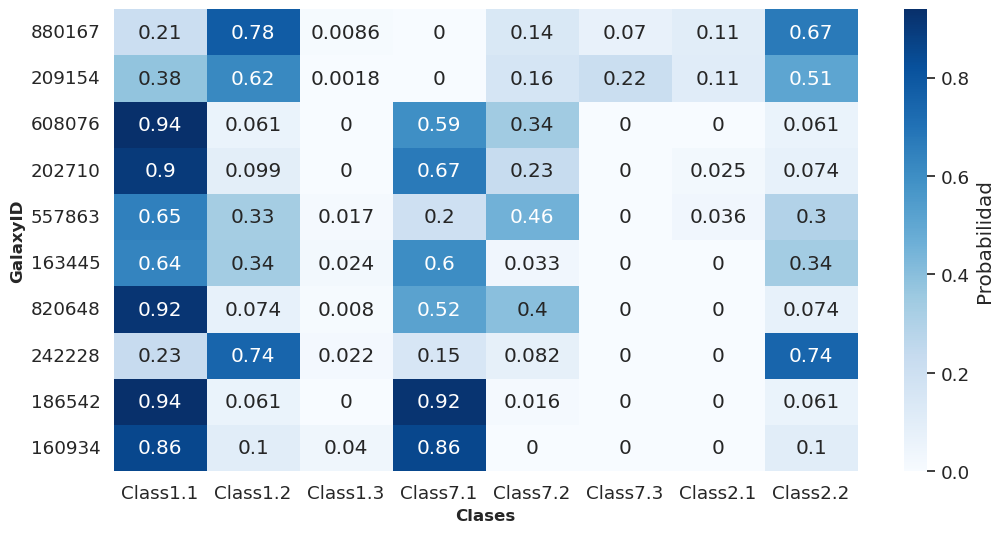

In [449]:
# Heatmap de probabilidades para las distintas clases
# 7.1 7.2 y 7.3 son subclases de 1.1, y suman su probabilidad
# 2.1 y 2.2 son subclases de 1.2, y suman su probabilidad

plt.figure(figsize=(12,6))
ax = sns.heatmap(df_train_sol.sample(frac=1).head(10).set_index('GalaxyID'), annot=True, cmap='Blues', cbar_kws={'label': 'Probabilidad'})
plt.xlabel('Clases',fontsize=12, fontweight='bold')
plt.ylabel('GalaxyID',fontsize=12, fontweight='bold')

In [450]:
# Comprobando que sume 1 cada muestra
df_train_sol[['Class1.1', 'Class1.2', 'Class1.3']].sum(axis=1).unique()

array([1.      , 1.      , 0.999999, 1.000001, 0.999999, 1.000001,
       0.999999, 1.      ])

In [451]:
# Verificando presencia de nulos o muestras duplicadas
nulos_totales = df_train_sol.isnull().sum().sum()
duplicados_totales = df_train_sol.duplicated().sum()
print('Valores nulos totales: {}'.format(nulos_totales))
print('Valores duplicados: {}'.format(duplicados_totales))

Valores nulos totales: 0
Valores duplicados: 0


In [452]:
# Como exploración básica, se muestran los estadisticos principales
df_train_sol.describe()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
count,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000,61578.000000
mean,550179.708337,0.432526,0.542261,0.025213,0.170021,0.207765,0.054740,0.106408,0.435854
std,258724.130197,0.283517,0.296429,0.037967,0.238860,0.215967,0.110445,0.212505,0.301867
min,100008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,327874.250000,0.175812,0.280862,0.000000,0.000000,0.032554,0.000000,0.000000,0.168490
50%,551933.000000,0.416994,0.558754,0.014870,0.035954,0.125757,0.000000,0.000000,0.394850
75%,773232.000000,0.679182,0.811339,0.034325,0.280679,0.333788,0.049136,0.085161,0.694615
max,999967.000000,1.000000,1.000000,0.935147,1.000000,1.000000,0.883481,1.000000,1.000000


# Etiquetas

In [454]:
print(df_all.columns)

Index(['GalaxyID', 'Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2',
       'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2',
       'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2',
       'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5',
       'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
       'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
       'Class11.4', 'Class11.5', 'Class11.6'],
      dtype='object')


In [455]:
# Fist level
df1 = df_all[['Class1.1','Class1.2','Class1.3']] # Principal

# Second level
df2 = df_all[['Class7.1','Class7.2','Class7.3']] # viene clase 1.1
df3 = df_all[['Class2.1','Class2.2']] # viene de clase 1.2

# Third level
df4 = df_all[['Class9.1','Class9.2','Class9.3']] # Viene de 2.1
df5 = df_all[['Class3.1','Class3.2']] # viene de 2.2

# Forth level
df6 = df_all[['Class4.1','Class4.2']] # viene de 3.1 y 3.2

df7 = df_all[['Class10.1','Class10.2','Class10.3']] # viene de 4.1
df8 = df_all[['Class11.1','Class11.2','Class11.3','Class11.4','Class11.5','Class11.6']] # viene de 10

df9 = df_all[['Class5.1','Class5.2','Class5.3','Class5.4']] # viene de 11

# Fifth level
df9 = df_all[['Class6.1','Class6.2']] # viene de 5, 7 y 9

df10 = df_all[['Class8.1','Class8.2','Class8.3','Class8.4','Class8.5','Class8.6','Class8.7']] # ultimo

In [456]:
df = df_train_sol.set_index('GalaxyID')
df.head()

,Class1.1,Class1.2,Class1.3,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
GalaxyID,,,,,,,,
100008,0.383147,0.616853,0.000000,0.201463,0.181684,0.000000,0.000000,0.616853
100023,0.327001,0.663777,0.009222,0.000000,0.135082,0.191919,0.031178,0.632599
100053,0.765717,0.177352,0.056931,0.000000,0.741864,0.023853,0.000000,0.177352
100078,0.693377,0.238564,0.068059,0.408599,0.284778,0.000000,0.000000,0.238564
100090,0.933839,0.000000,0.066161,0.494587,0.439252,0.000000,0.000000,0.000000


In [457]:
df1 = df1.set_index(df.index)
df2 = df2.set_index(df.index)
df3 = df3.set_index(df.index)
df4 = df4.set_index(df.index)
df5 = df5.set_index(df.index)
df6 = df6.set_index(df.index)
df7 = df7.set_index(df.index)
df8 = df8.set_index(df.index)
df9 = df9.set_index(df.index)
df10 = df10.set_index(df.index)

In [458]:
df1.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.383147,0.616853,0.000000
100023,0.327001,0.663777,0.009222
100053,0.765717,0.177352,0.056931
100078,0.693377,0.238564,0.068059
100090,0.933839,0.000000,0.066161


In [459]:
def row_class(df, unc=True, unc_value=0.3): # Included uncertainty filter
    rows, cols = df.shape
    if unc==True:
        for i in range(rows):
            idx = df.iloc[i].values.argmax()
            row = np.zeros(cols)
            if np.sum(np.delete(df.iloc[i].values,idx)) > unc_value:
                row[idx] = np.NaN
                df.iloc[i] = row
            else:
                row[idx] = 1
                df.iloc[i] = row
    else:
        for i in range(rows):
            idx = df.iloc[i].values.argmax()
            row = np.zeros(cols)
            row[idx] = 1
            df.iloc[i] = row
            
    return df.dropna()

In [460]:
# Side note, what if we use uncertainty?
example = row_class(df1.copy(), unc=True, unc_value=0.3) # menor unc, mas estricto

In [461]:
example

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100053,1.0,0.0,0.0
100090,1.0,0.0,0.0
100122,1.0,0.0,0.0
100134,0.0,1.0,0.0
100143,0.0,1.0,0.0
...,...,...,...
999875,0.0,1.0,0.0
999950,1.0,0.0,0.0
999958,0.0,1.0,0.0


In [462]:
df1.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100008,0.383147,0.616853,0.000000
100023,0.327001,0.663777,0.009222
100053,0.765717,0.177352,0.056931
100078,0.693377,0.238564,0.068059
100090,0.933839,0.000000,0.066161


In [463]:
df1 = row_class(df1, unc=True, unc_value=0.3)
df2 = row_class(df2, unc=True, unc_value=0.3)
df3 = row_class(df3, unc=True, unc_value=0.3)
df4 = row_class(df4, unc=True, unc_value=0.3)
df5 = row_class(df5, unc=True, unc_value=0.3)
df6 = row_class(df6, unc=True, unc_value=0.3)
df7 = row_class(df7, unc=True, unc_value=0.3)
df8 = row_class(df8, unc=True, unc_value=0.3)
df9 = row_class(df9, unc=True, unc_value=0.3)
df10 = row_class(df10, unc=True, unc_value=0.3)

## Primer nivel - Elipticas, espirales y artefactos

In [465]:
df1.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100053,1.0,0.0,0.0
100090,1.0,0.0,0.0
100122,1.0,0.0,0.0
100134,0.0,1.0,0.0
100143,0.0,1.0,0.0


## Segundo nivel - Que tan redondeada?

In [467]:
# Indices para imagenes que son elipticas
idx2 = df1[df1['Class1.1']==1.0].index
idx2

Int64Index([100053, 100090, 100122, 100295, 100428, 100434, 100444, 100458,
            100479, 100571,
            ...
            999475, 999508, 999569, 999604, 999655, 999680, 999781, 999786,
            999950, 999967],
           dtype='int64', name='GalaxyID', length=14146)

In [468]:
# Modifica dataframe segun nuevos indices
df2 = df2.reindex(idx2).dropna()
df2

,Class7.1,Class7.2,Class7.3
GalaxyID,,,
100053,0.0,1.0,0.0
100122,0.0,1.0,0.0
100295,0.0,1.0,0.0
100428,1.0,0.0,0.0
100434,1.0,0.0,0.0
...,...,...,...
999569,0.0,1.0,0.0
999604,0.0,1.0,0.0
999655,1.0,0.0,0.0


## Segundo nivel - Es vista desde el borde?

In [470]:
# Indices para espirales
idx3 = df1[df1['Class1.2']==1.0].index
idx3

Int64Index([100134, 100143, 100237, 100263, 100322, 100335, 100380, 100382,
            100445, 100474,
            ...
            999354, 999415, 999423, 999502, 999685, 999777, 999795, 999875,
            999958, 999964],
           dtype='int64', name='GalaxyID', length=22666)

In [471]:
# Se aplican indices
df3 = df3.reindex(idx3).dropna()
df3

,Class2.1,Class2.2
GalaxyID,,
100134,0.0,1.0
100143,1.0,0.0
100237,0.0,1.0
100263,1.0,0.0
100322,1.0,0.0
...,...,...
999777,0.0,1.0
999795,0.0,1.0
999875,0.0,1.0


In [472]:
# Cuantas muestras hay por clase?
df1.sum()

Class1.1    14146.0
Class1.2    22666.0
Class1.3        6.0
dtype: float64

In [473]:
df2.sum().sort_values()

Class7.3     214.0
Class7.2    5244.0
Class7.1    6118.0
dtype: float64

In [474]:
df3.sum().sort_values()

Class2.1     4117.0
Class2.2    17456.0
dtype: float64

In [475]:
df1_sum = pd.Series({'Class1.1':df2.sum().sum(), 'Class1.2':df3.sum().sum()}) 
df1_sum

Class1.1    11576.0
Class1.2    21573.0
dtype: float64

## Conteo por clases (principales)

In [497]:
df_class = pd.concat([df1_sum,df2.sum(),df3.sum()])
df_class

Class1.1    11576.0
Class1.2    21573.0
Class7.1     6118.0
Class7.2     5244.0
Class7.3      214.0
Class2.1     4117.0
Class2.2    17456.0
dtype: float64

In [531]:
df_class.sum()

66298.0

In [511]:
df_class[['Class1.1', 'Class1.2']]

Class1.1    11576.0
Class1.2    21573.0
dtype: float64

(0.0, 30000.0)

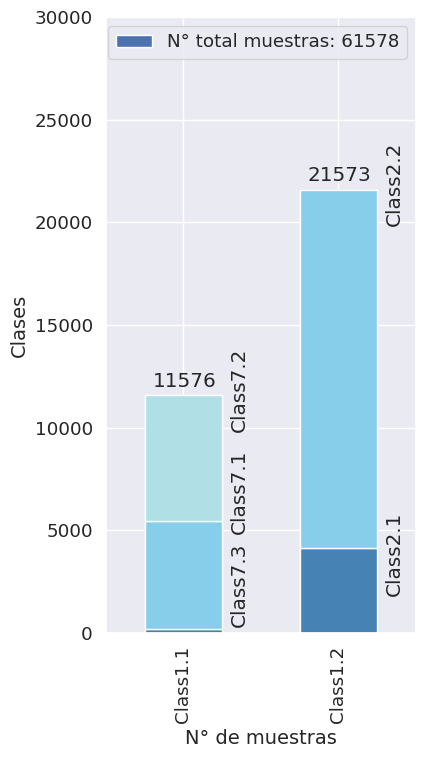

In [529]:
plt.figure(figsize=(4,8))
#df_class.reset_index().iloc[['Class1.1', 'Class1.2', 'Class1.3']].sum().plot(kind='bar')
df_class[['Class1.1', 'Class1.2']].plot(kind='bar')

x = ['Class1.1', 'Class1.2']
y1 = np.array([df2.sum().sort_values()[0], df3.sum().sort_values()[0]])
y2 = np.array([df2.sum().sort_values()[1], df3.sum().sort_values()[1]])
y3 = np.array([df2.sum().sort_values()[2], np.NaN])
plt.bar(x, y1, width=0.5, color='steelblue')
plt.bar(x, y2, bottom=y1, width=0.5, color='skyblue')
plt.bar(x, y3, bottom=y2+y1, width=0.5, color='powderblue')

plt.annotate('11576',(-0.2, 12000))
plt.annotate('21573',(0.80, 22000))
#plt.annotate('59',(1.9, 1000))

plt.annotate('Class7.2',(0.3, 10000), rotation=90)
plt.annotate('Class7.1',(0.3, 5000), rotation=90)
plt.annotate('Class7.3',(0.3, 500), rotation=90)

plt.annotate('Class2.2',(1.3, 20000), rotation=90)
plt.annotate('Class2.1',(1.3, 2000), rotation=90)

plt.legend(['N° total muestras: 61578'])
plt.ylabel('Clases', fontsize=14)
plt.xlabel('N° de muestras', fontsize=14)
plt.ylim([0, 30000])

## Conteo por clases (todas)

In [ ]:
df1.info() # Principales (elipticas, espirales u otras)

In [ ]:
df2.info() # Elipticas (que tan redondas)

In [ ]:
df3.info() # Espirales (es vista de borde?)

In [ ]:
df4.info() # Espirales vistas de borde (que forma tiene el centro?)

# Reindex
idx4 = df3[df3['Class2.1']==1.0].index

df4 = df4.reindex(idx4)
df4.info()

In [ ]:
df5.info() # Espirales vistas desde otro angulo (tiene alguna barra en el centro?)

# Reindex
idx5 = df3[df3['Class2.2']==1.0].index

df5 = df5.reindex(idx5)
df5.info()

In [ ]:
df6.info() # Espirales vistas desde otro angulo (tiene patron espiral?)

# Reindex
idx5 = df3[df3['Class2.2']==1.0].index

df6 = df6.reindex(idx5)
df6.info()

In [ ]:
df7.info() # espirales con patron espiral (que tan curvadas?)

# Reindex
idx6 = df6[df6['Class4.1']==1.0].index

df7 = df7.reindex(idx6)
df7.info()

In [ ]:
df8.info() # espirales con patron espiral (cuantos brazos tiene?)

# Reindex
idx6 = df6[df6['Class4.1']==1.0].index

df8 = df8.reindex(idx6)
df8.info()

In [ ]:
df_count = pd.concat([df1.sum(),df2.sum(),df3.sum(),df4.sum(),df5.sum(),df6.sum(),df7.sum(),df8.sum()])
df_count

In [ ]:
df_count.plot(kind='bar')

## Gráficos para muestras aleatorias y comportamiento de clases

In [149]:
# Dataframe con probabilidades con clase
df_train_sol = df_train_sol[['GalaxyID','Class1.1','Class1.2','Class1.3']]

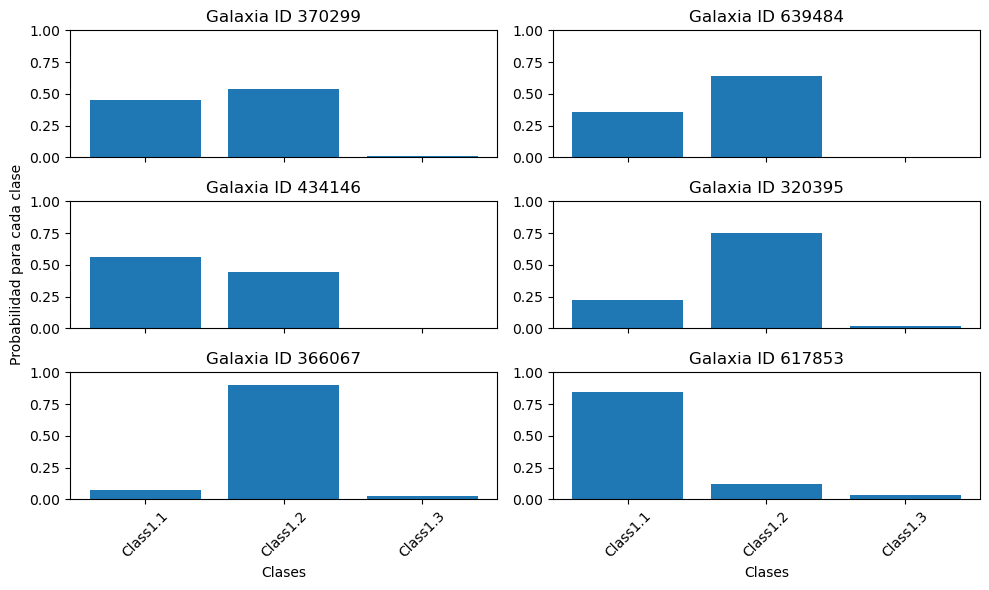

In [151]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True)

x = np.arange(1,len(df_train_sol)) # indices posibles

for i in range(6):
    idx = random.choice(x) # Aleatoriza la muestra para mejor analisis
    etiquetas = df_train_sol.columns[1:]
    alturas = df_train_sol.iloc[idx, 1:].tolist()

    row, col = divmod(i, 2)
    ax = axes[row, col]

    ax.bar(etiquetas, alturas)
    if i==2:
         ax.set_ylabel('Probabilidad para cada clase')
    if i>=4:
        ax.set_xlabel('Clases')
        ax.tick_params(axis='x', rotation=45)
    
    ax.set_title('Galaxia ID {}'.format(df_train_sol['GalaxyID'][idx]))
    ax.set_ylim([0,1])

plt.tight_layout()
plt.show()

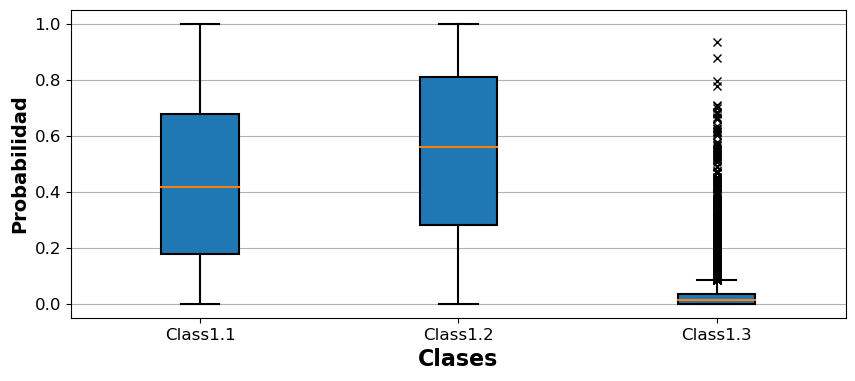

In [152]:
# Se muestra la probabilidad por clase de todas las muestras en forma de boxplot
fig, ax = plt.subplots(1,1,figsize=(10, 4))
df = df_train_sol[df_train_sol.columns[1:]]

box = df.plot(kind='box', ax=ax, fontsize=12, patch_artist=True,
             color=dict(boxes='r', whiskers='r', medians='r', caps='r'),
             boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(marker='x'),
             medianprops=dict(linestyle='-', linewidth=1.5),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=True, rot=0)

ax.yaxis.grid(True)
ax.set_xlabel('Clases', fontsize=16, fontweight='bold')
ax.set_ylabel('Probabilidad', fontsize=14, fontweight='bold')
plt.show()

In [155]:
path_train = 'images_training_rev1/'
path_test = 'images_test_rev1/'

In [157]:
def plot_random_galaxy(path, sample = 4):
    random_image=random.sample(os.listdir(path),sample)
 
    plt.figure(figsize=(16,5))
    for i in range(sample):
        
        plt.subplot(1,sample,i+1)
        img=tf.io.read_file(os.path.join(path,random_image[i]))
        img=tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'GalaxyID: {random_image[i][:-4]}', fontsize=14, fontweight='bold')
        plt.axis(False)

Se grafican muestras aleatorias para mostrar el tipo de datos que se manejará (imágenes)

2024-07-17 02:37:26.987569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 02:37:26.988217: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


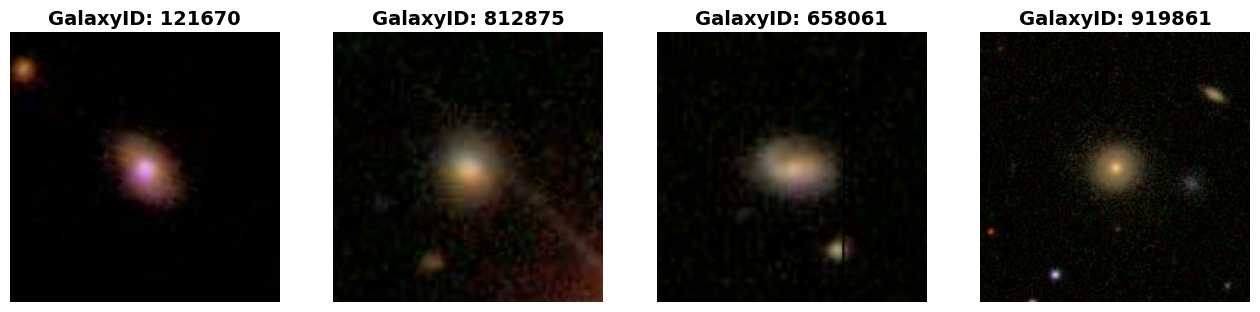

In [160]:
plot_random_galaxy(path_train)

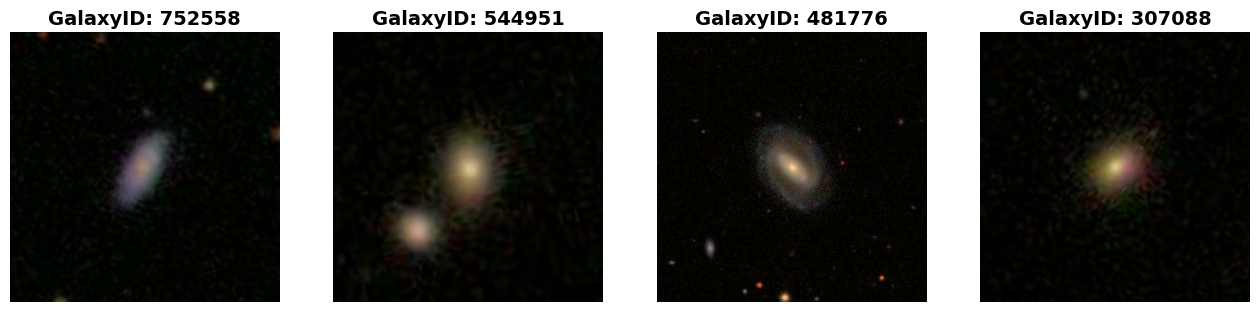

In [161]:
plot_random_galaxy(path_test)

# Preparaciones

In [165]:
# Lista de archivos de entrenamiento
files = os.listdir(path_train)
files.sort()

In [167]:
# Checking info of image, minmax and resolution
image = Image.open(path_train + files[0])

print("Infor. Imagen")
print(image.format)
print(image.size)
print(image.mode)

Infor. Imagen
JPEG
(424, 424)
RGB


In [169]:
# Transformaciones y augmentation
transform_image = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomRotation(360), # Not sure about this one
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.CenterCrop(224),
                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_valtest = transforms.Compose([transforms.ToTensor(),
                                       transforms.CenterCrop(224),
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [171]:
# Modelo
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg") # 384 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14") # 768 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitl14") # 1024 emb
#model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14") # 1536 emb

Using cache found in /home/martin/.cache/torch/hub/facebookresearch_dinov2_main
/home/martin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/martin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/martin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [172]:
#model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg_lc')

In [173]:
torch.cuda.is_available()

True

In [177]:
# Usar GPU si esta disponible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Current device:',device)
model.to(device)

#for id, module in enumerate(model.named_modules()):
#    print(id,module)

Current device: cuda


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Etiquetas (binario)

In [180]:
df_class = df1

In [182]:
df_class.head()

,Class1.1,Class1.2,Class1.3
GalaxyID,,,
100053,1.0,0.0,0.0
100090,1.0,0.0,0.0
100122,1.0,0.0,0.0
100134,0.0,1.0,0.0
100143,0.0,1.0,0.0


In [184]:
# Si es necesario quitar la 3ra clase:
y = df_class[df_class['Class1.3']!=1.0]
y = y.drop(columns='Class1.3')
#y2['target'] = y2.target - 1
y.head()

# Con esto queda un problema binario de clasificacion con 0 = eliptico, 1 = espiral

,Class1.1,Class1.2
GalaxyID,,
100053,1.0,0.0
100090,1.0,0.0
100122,1.0,0.0
100134,0.0,1.0
100143,0.0,1.0


## Etiquetas multiclase (3 clases)

In [186]:
# Se considera elipticas y espirales vistas desde el lado u otro angulo
y.head() # Ya contiene el caso binario

,Class1.1,Class1.2
GalaxyID,,
100053,1.0,0.0
100090,1.0,0.0
100122,1.0,0.0
100134,0.0,1.0
100143,0.0,1.0


In [188]:
# Para hacer el caso 3 clases, es necesario reemplazar la columna 1.2 por el dataframe df3, que tiene el one-hot encoding de las espirales
df3.head()

,Class2.1,Class2.2
GalaxyID,,
100134,0.0,1.0
100143,1.0,0.0
100237,0.0,1.0
100263,1.0,0.0
100322,1.0,0.0


In [190]:
# Dropear y concatenar ambas
y_3c = pd.concat([y.drop(columns=['Class1.2']), df3], axis=1)
y_3c = y_3c.fillna(.0)
y_3c.head()

,Class1.1,Class2.1,Class2.2
GalaxyID,,,
100053,1.0,0.0,0.0
100090,1.0,0.0,0.0
100122,1.0,0.0,0.0
100134,0.0,0.0,1.0
100143,0.0,1.0,0.0


<AxesSubplot:>

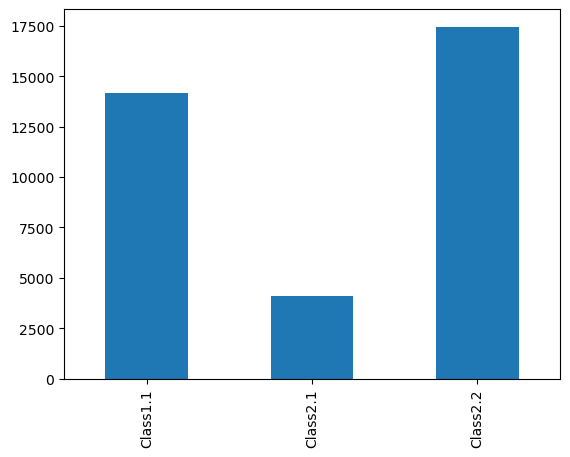

In [192]:
# Hay que darle una manito de gato a este grafico
y_3c.sum().plot(kind='bar')

## Etiquetas multiclase (5 clases)

In [194]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36812 entries, 100053 to 999967
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Class1.1  36812 non-null  float64
 1   Class1.2  36812 non-null  float64
dtypes: float64(2)
memory usage: 1.9 MB


In [196]:
df2.head()

,Class7.1,Class7.2,Class7.3
GalaxyID,,,
100053,0.0,1.0,0.0
100090,NaN,NaN,NaN
100122,0.0,1.0,0.0
100295,0.0,1.0,0.0
100428,1.0,0.0,0.0


In [198]:
#df2["Class7.1+7.2"] = df2['Class7.1'] + df2['Class7.2']
#df2 = df2.drop(columns=['Class7.1','Class7.2'])

In [200]:
#df2 = df2.drop(columns=['Class7.3']) # Otra opcion, ya que 7.3 esta desbalanceada

In [202]:
df3.head()

,Class2.1,Class2.2
GalaxyID,,
100134,0.0,1.0
100143,1.0,0.0
100237,0.0,1.0
100263,1.0,0.0
100322,1.0,0.0


In [204]:
# Dropear y concatenar ambas
y_4c = pd.concat([df2, df3], axis=1)
y_4c = y_4c.fillna(.0)

y_4c.head()

,Class7.1,Class7.2,Class7.3,Class2.1,Class2.2
GalaxyID,,,,,
100053,0.0,1.0,0.0,0.0,0.0
100090,0.0,0.0,0.0,0.0,0.0
100122,0.0,1.0,0.0,0.0,0.0
100295,0.0,1.0,0.0,0.0,0.0
100428,1.0,0.0,0.0,0.0,0.0


In [206]:
y_4c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36812 entries, 100053 to 999964
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Class7.1  36812 non-null  float64
 1   Class7.2  36812 non-null  float64
 2   Class7.3  36812 non-null  float64
 3   Class2.1  36812 non-null  float64
 4   Class2.2  36812 non-null  float64
dtypes: float64(5)
memory usage: 1.7 MB


<AxesSubplot:>

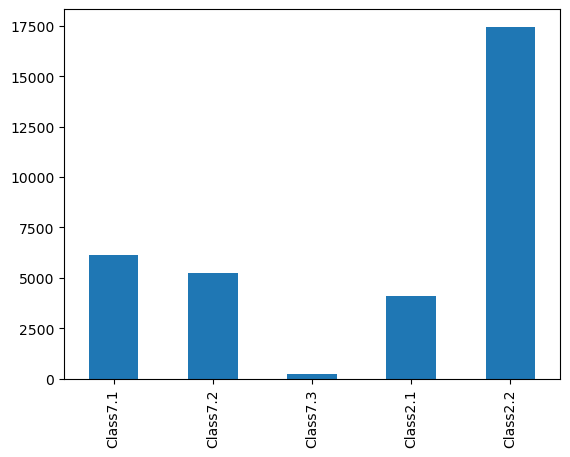

In [208]:
# Hay que darle una manito de gato a este grafico
y_4c.sum().plot(kind='bar')

## GalaxyID a imagen

In [211]:
# Función para obtener imagen y etiqueta según GalaxyID
def ID2img(ID):
    #label = y.loc[ID].values
    
    img = path_train + str(ID)+'.jpg'
    img = Image.open(img)
    return img#, label

### Ejemplo 1 imagen

In [214]:
# Obtiene imagen y etiqueda para la primera GalaxyID
img = ID2img(y.index.values[1])

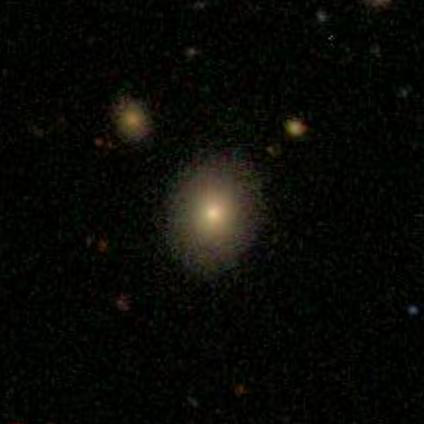

In [216]:
# Imagen
img

In [218]:
# Transformaciones
img = transform_image(img).unsqueeze(0)
print(img.size())

torch.Size([1, 3, 224, 224])


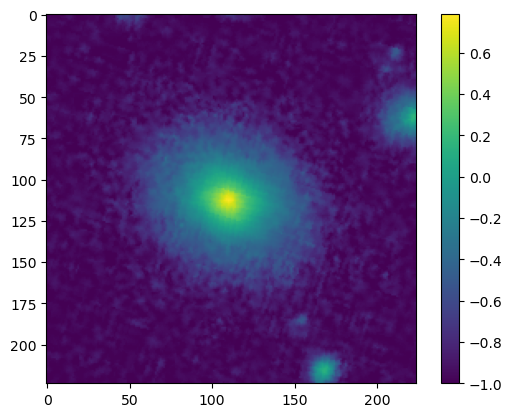

In [220]:
plt.imshow(img[0,0,:,:])
plt.colorbar()

In [222]:
# Obtener embedding (este proceso será interno en la arquitectura)
emb = model(img.cuda()) # Quitar .cuda si no hay gpu

/home/martin/anaconda3/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608885084/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


In [223]:
emb.size()

torch.Size([1, 384])

In [226]:
model_output = emb.squeeze().size(0)

### Que targets usar?

In [229]:
# Datos a utilizar para entrenamiento, considerar que se usará ID2img y transforms especificados más arriba
X = y_3c.index.values
y = y_3c.to_numpy()

In [231]:
X

array([100053, 100090, 100122, ..., 999958, 999964, 999967])

In [233]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

# Dataset y Dataloader

In [236]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20)

In [238]:
print("Size train:", X_train.shape)
print("Size val:", X_val.shape)
print("Size test:", X_test.shape)

Size train: (23559,)
Size val: (5890,)
Size test: (7363,)


In [240]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long) 

In [242]:
class CDataset(torch.utils.data.Dataset):
    # CustomDataset modificado de código de prácticas.
    def __init__(self, galaxyid, labels, tfr, tfr_model):
        self.data = galaxyid # X
        self.labels = labels # y
        self.transform = tfr
        self.transform_model = tfr_model

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        ID = self.data[idx]
        img = ID2img(ID) # unsqueeze(0)
        
        if self.transform:
            img = self.transform(img)
            img = self.transform_model(img.cuda().unsqueeze(0)).squeeze(0) # quitar .cuda() si no usa gpu
            
        return img.cpu(), self.labels[idx] # Se transforma a cpu para que la capa FF se trabaje en cpu

In [244]:
class CDataloader(torch.utils.data.DataLoader):
    def __init__(self, Xtrain, ytrain, Xval, yval, Xtest, ytest,
                    tfr_train  = None,
                    tfr_val    = None,
                    tfr_test   = None,
                    tfr_model  = None,
                    batch_size = 64,
                    shuffle    = False):

        # Atributes and labels
        self.xtrain, self.ytrain = Xtrain, ytrain
        self.xval, self.yval     = Xval, yval
        self.xtest, self.ytest   = Xtest, ytest

        # Number of categories
        self.nb_labels = self.ytrain.size(1)

        # Transformations
        self.tfr_train = tfr_train
        self.tfr_val   = tfr_val
        self.tfr_test  = tfr_test
        
        self.tfr_model = tfr_model

        # Loader
        self.__loader(batch_size, shuffle)

    def __loader(self, batch_size, shuffle):
        
        # Create the Datasets
        train_set = CDataset(galaxyid = self.xtrain, labels = self.ytrain, tfr=self.tfr_train, tfr_model = self.tfr_model)
        val_set   = CDataset(galaxyid = self.xval  , labels = self.yval  , tfr=self.tfr_val,   tfr_model = self.tfr_model)
        test_set  = CDataset(galaxyid = self.xtest , labels = self.ytest , tfr=self.tfr_test,  tfr_model = self.tfr_model)

        # Create the Dataloaders
        self.train_set = torch.utils.data.DataLoader(dataset   = train_set,
                                                    batch_size = batch_size,
                                                    shuffle    = shuffle)

        self.val_set   = torch.utils.data.DataLoader(dataset   = val_set,
                                                    batch_size = batch_size,
                                                    shuffle    = False)
        
        self.test_set  = torch.utils.data.DataLoader(dataset   = test_set,
                                                    batch_size = batch_size,
                                                    shuffle    = False)

In [246]:
# Ejecucion datos
loader = CDataloader(Xtrain = X_train, ytrain = y_train, Xval = X_val, yval = y_val, Xtest = X_test, ytest = y_test,
                                tfr_train  = transform_image,
                                tfr_val    = transform_valtest,
                                tfr_test   = transform_valtest,
                                tfr_model  = model,
                                batch_size = 16, # Con este valor la gpu ocupa ~3 gb de vram
                                shuffle    = True)

print(f"CDataloader fue ejecutado correctamente")
print(110*"_")

# Checking input size and number of classes ---------------------------------------------------------#
input_size  = loader.train_set.dataset.data.shape 
num_classes = loader.nb_labels

print(f"Input del dataset:        {input_size}")
print(f"Cantidad de categorias:   {num_classes}")

CDataloader fue ejecutado correctamente
______________________________________________________________________________________________________________
Input del dataset:        (23559,)
Cantidad de categorias:   3


In [402]:
# Testing functionality of loader
#train_features, train_labels = next(iter(loader.test_set))

#print("Loader train_data batch size :", train_features.size())
#print("Loader train_label batch size:", train_labels.size())

In [404]:
# Revisemos embeddings desde Dataloader
#img = train_features[0].squeeze()
#label = train_labels[0]
#plt.imshow(img[0,:,:])
#plt.colorbar()
#plt.show()
#print(f"Label: {label}")

# Trainer

In [248]:
class EarlyStopping:
    # EarlyStopping basado en la métrica (Accuracy)
    def __init__(self, patience=5, delta=0.001, verbose=False):
        # Inicializar parámetros
        self.best_metric = -np.Inf 
        self.counter = 0
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
    
    # Contador para EarlyStopping
    def count(self, metric):
        # Si métrica es mejor que la anterior + delta, is_best = True
        is_best = bool(metric > (self.best_metric+self.delta))

        # Actualizamos el valor del contador
        if is_best: # Si is_best = True, reiniciar contador
            print(f'Incremento en Accuracy: [{self.best_metric:.6f} > {metric:.6f}]. Creando checkpoint.')
            self.counter = 0
        else: # Caso contrario, incrementar contador para EarlyStopping
            print(f'Sin mejora en Accuracy: [{self.counter}/{self.patience}]')
            self.counter += 1

        # Actualizamos métrica si es mayor a la ya definida
        self.best_metric = max(metric, self.best_metric)

        # Analizamos si es necesario o no detener el entrenamiento
        stop = bool(self.counter > self.patience)

        return stop, is_best

In [250]:
class CTrainer(object):
    def __init__(self, arch, hyper, model_instance, verbose=True):
        super(CTrainer, self).__init__()
        self.architecture   = arch                                                # Parametros de la red
        self.hyperparams    = hyper                                               # Hiperparametros del modelo
        self.model_class    = model_instance                                      # Modelo que usaremos
        self.verbose        = verbose                                             # Si desamos o no los prints
        
    def compile(self, load_checkpoint):
        self.model      = self.model_class(self.architecture)
        self.loss       = torch.nn.CrossEntropyLoss() 
        self.optimizer  = torch.optim.Adam(params=self.model.parameters(), lr = self.hyperparams["lr"])
        self.early_stop = EarlyStopping(patience=self.hyperparams["patience"], delta=0.001)
        
        # Añadido un esquema de learning rate
        if self.hyperparams['schedule_lr']: # Se puede cambiar schedule
            self.scheduler  = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.1, patience=1)
            print("Scheduler LR: Activated")
        else:
            self.scheduler  = optim.lr_scheduler.LinearLR(self.optimizer, start_factor = self.hyperparams["lr"],
                                                          end_factor = self.hyperparams["lr"], total_iters = 100)
            print("Scheduler LR: Deactivated")
            
        self.history   = {  "epochs"    : [],
                            "train_loss": [], "train_metric":[],
                            "val_loss"  : [], "val_metric"  :[]}

        if load_checkpoint:
            state_dict = torch.load('{}/trained_parameters.pth'.format(self.hyperparams["exp"]))

            self.model.load_state_dict(state_dict['model'])
            self.optimizer.load_state_dict(state_dict['optim'])

            print('Training parameters restored.')
            
    def fit(self, train_dl, val_dl):
        for epoch in range(0, self.hyperparams["nepochs"]+1):
            train_loss, train_metric = self.__train_one_epoch(train_dl)
            val_loss  , val_metric   = self.__val_one_epoch(val_dl)

            epoch_train_loss     = np.mean(train_loss)
            epoch_train_metric   = np.mean(train_metric)

            epoch_val_loss       = np.mean(val_loss)
            epoch_val_metric     = np.mean(val_metric)

            if self.verbose:
                print(f'\nEpoch: {epoch}/{self.hyperparams["nepochs"]} '
                        + f'loss = {epoch_train_loss:.4f}, '
                        + f'metric = {epoch_train_metric:.4f}, ')

            self.history["epochs"].append(epoch)
            self.history["train_loss"].append(epoch_train_loss)
            self.history["train_metric"].append(epoch_train_metric)
            self.history["val_loss"].append(epoch_val_loss)
            self.history["val_metric"].append(epoch_val_metric)

            stop, is_best = self.early_stop.count(epoch_val_metric)
            
            self.scheduler.step(epoch_val_metric)

            if is_best:
                cpkt = {'model': self.model.state_dict(),
                        'optim': self.optimizer.state_dict()}
                torch.save(cpkt, './{}/trained_parameters.pth'.format(self.hyperparams["exp"]))
                print("")
            if stop:
                break

    def summary(self):
        print(110*"_")
        print(self.model)
        for layer, param in self.model.named_parameters():
            print(100*"-")
            print(f'layer.param_type:    {layer}')
            print(f"n-params        :    {param.numel()}")
            print(100*"-")
        print(110*"_")

    def __train_one_epoch(self, dataloader):
        self.model.train()

        train_loss   = []
        train_metric = []

        for X_train, y_train in tqdm(dataloader, miniters=1):
            y_pred       = self.model(X_train.float())

            score_loss   = self.loss(y_pred, y_train.float())

            y            = torch.argmax(y_train, dim=-1).detach().numpy()
            y_hat        = torch.argmax(y_pred , dim=-1).detach().numpy()
            score_metric = accuracy_score(y, y_hat)

            # back, step, zero
            score_loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad(set_to_none=True)

            train_loss.append(score_loss.item())
            train_metric.append(score_metric)
        return train_loss, train_metric

    def __val_one_epoch(self, dataloader):
        self.model.eval()

        val_loss   = []
        val_metric = []

        with torch.no_grad():
            for X_val, y_val in tqdm(dataloader, miniters=1):
                y_preds_val  = self.model(X_val.float())

                score_loss   = self.loss(y_preds_val, y_val.float())

                y            = torch.argmax(y_val, dim=-1).detach().numpy()
                y_hat        = torch.argmax(y_preds_val , dim=-1).detach().numpy()
                score_metric = accuracy_score(y, y_hat)

                val_loss.append(score_loss.item())
                val_metric.append(score_metric)
        return val_loss, val_metric

    def evaluate(self, dataloader):
        self.model.eval()

        loss_list   = []
        metric_list = []

        with torch.no_grad():
            for X_test, y_test in tqdm(dataloader, miniters=1):
                y_preds_test = self.model(X_test.float())

                score_loss   = self.loss(y_preds_test, y_test.float())

                y            = torch.argmax(y_test, dim=-1).detach().numpy()
                y_hat        = torch.argmax(y_preds_test , dim=-1).detach().numpy()
                score_metric = accuracy_score(y, y_hat)

                loss_list.append(score_loss.item())
                metric_list.append(score_metric)

                loss_out = np.mean(loss_list)
                metric   = np.mean(metric_list)
        return loss_out, metric

    def predict(self, X):
        self.model.eval()

        y_pred_prob = []
        y_pred      = []

        with torch.no_grad():
            X      = X.float()
            out    = self.model(X)

            y_hat_prob = torch.nn.functional.softmax(out)
            y_hat      = torch.argmax(y_hat_prob)
        return y_hat_prob, y_hat

# Arquitectura

In [252]:
class DinoV2Classifier(nn.Module):
    def __init__(self, Args_dict):
        super(DinoV2Classifier, self).__init__()
        emb_size = Args_dict["emb_size"]
        out_size = Args_dict["out_size"]
        
        self.act1 = nn.ReLU()
        #self.act2 = nn.Sigmoid()
        
        #self.drop = nn.Dropout(p=0.1)
        
        self.fc1 = nn.Linear(emb_size, 256)
        self.fc2 = nn.Linear(256, 64) # 64
        self.fc3 = nn.Linear(64, out_size)
        
        #self.ViT = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14_reg").to('cuda')
        
    def forward(self, x): 
        #x = self.ViT(x.cuda())
        x = self.act1(self.fc1(x)) #.cpu()))
        x = self.act1(self.fc2(x)) #act1
        x = self.fc3(x)
        #x = self.dinoclf(x)
        return x

# Compilación

In [254]:
architecture = {"emb_size": model_output, "out_size": num_classes}
hyperparams  = {"nepochs": 30, "lr":0.01, "patience": 3, "exp": "./Model/", 'schedule_lr': True}

In [449]:
## Para desactivar la gradiente en ciertas capas de dino
def disable_gradients(module):
    for param in module.parameters():
        param.requires_grad = False

    for child in module.children():
        disable_gradients(child)

In [450]:
## Verify layers are frozen
def check_gradients(module):
    for name, param in module.named_parameters(recurse=False):
        print(f"Layer: {name}, requires_grad: {param.requires_grad}")
    for child_name, child in module.named_children():
        print(f"Entering child module: {child_name}")
        check_gradients(child)

In [256]:
DINO = CTrainer(arch = architecture, hyper = hyperparams, model_instance = DinoV2Classifier)
DINO.compile(load_checkpoint=False)

Scheduler LR: Activated


In [ ]:
for param in DINO.model.ViT.blocks[:11].parameters():
    param.requires_grad = False
    
check_gradients(DINO.model)

In [258]:
DINO.summary()

______________________________________________________________________________________________________________
DinoV2Classifier(
  (act1): ReLU()
  (fc1): Linear(in_features=384, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
)
----------------------------------------------------------------------------------------------------
layer.param_type:    fc1.weight
n-params        :    98304
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
layer.param_type:    fc1.bias
n-params        :    256
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
layer.param_type:    fc2.weight
n-params        :  

In [260]:
print("Entrenamiento DINOv2 Classifier")
print(110*"-")
DINO.fit(train_dl = loader.train_set, val_dl = loader.val_set)

Entrenamiento DINOv2 Classifier
--------------------------------------------------------------------------------------------------------------


  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 0/30 loss = 0.3248, metric = 0.8508, 
Incremento en Accuracy: [-inf > 0.870257]. Creando checkpoint.



  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 1/30 loss = 0.2769, metric = 0.8690, 
Incremento en Accuracy: [0.870257 > 0.886009]. Creando checkpoint.



  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 2/30 loss = 0.2593, metric = 0.8768, 
Incremento en Accuracy: [0.886009 > 0.891091]. Creando checkpoint.



  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 3/30 loss = 0.2432, metric = 0.8802, 
Sin mejora en Accuracy: [0/3]


  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 4/30 loss = 0.2465, metric = 0.8807, 
Sin mejora en Accuracy: [1/3]


  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 5/30 loss = 0.2112, metric = 0.8927, 
Incremento en Accuracy: [0.891091 > 0.899221]. Creando checkpoint.



  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 6/30 loss = 0.2082, metric = 0.8931, 
Incremento en Accuracy: [0.899221 > 0.901253]. Creando checkpoint.



  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 7/30 loss = 0.2065, metric = 0.8930, 
Sin mejora en Accuracy: [0/3]


  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 8/30 loss = 0.2092, metric = 0.8897, 
Sin mejora en Accuracy: [1/3]


  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 9/30 loss = 0.2012, metric = 0.8935, 
Sin mejora en Accuracy: [2/3]


  0%|          | 0/1473 [00:00<?, ?it/s]

  0%|          | 0/369 [00:00<?, ?it/s]


Epoch: 10/30 loss = 0.2013, metric = 0.8952, 
Sin mejora en Accuracy: [3/3]


# Performance

## Guardar resultados

In [266]:
# Curva de aprendizaje
# Extraer información necesaria del entrenamiento
epochs = DINO.history["epochs"]
loss = DINO.history["train_loss"]
loss_val = DINO.history["val_loss"]
metric = DINO.history["train_metric"]
metric_val = DINO.history["val_metric"]

In [268]:
# Guardar resultados modelo
results = np.array([epochs, loss, loss_val, metric, metric_val])
results = results.T

np.savetxt("Model/dino_results.txt", results)

## Cargar resultados

In [271]:
# Testing
DINO = CTrainer(arch = architecture, hyper = hyperparams, model_instance = DinoV2Classifier)
DINO.compile(load_checkpoint=True)

Scheduler LR: Activated
Training parameters restored.


In [264]:
# Cargar datos
results = np.loadtxt("Model/dino_results.txt")
results = results.T
epochs = results[0]
loss = results[1]
loss_val = results[2]
metric = results[3]
metric_val = results[4]

## Resultados

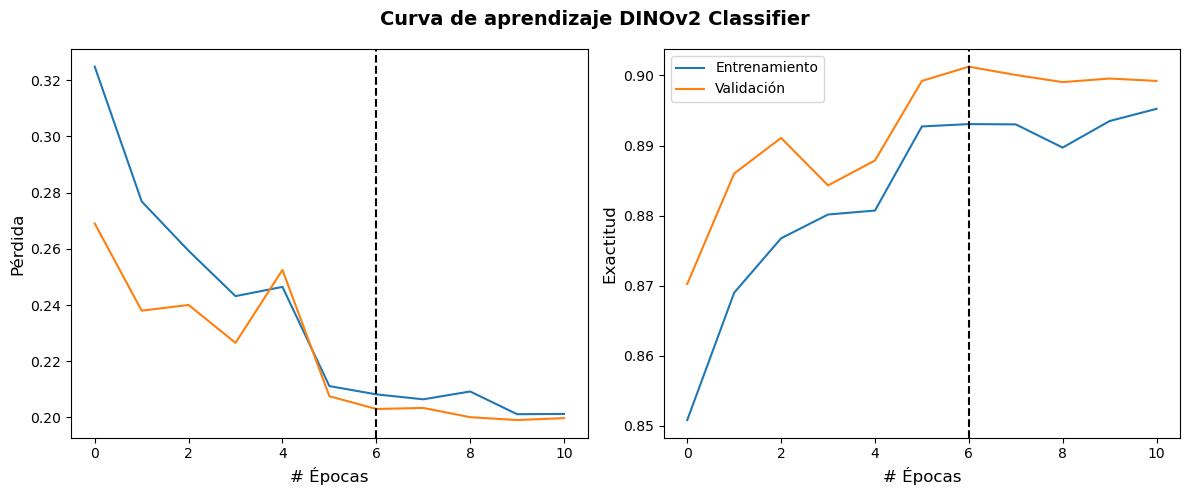

In [273]:
# Configuración de las subfiguras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Trazar la primera curva para Loss
axs[0].plot(epochs, loss)
axs[0].plot(epochs, loss_val)

best_pos = max(epochs)-hyperparams["patience"] # Mejor modelo
axs[0].axvline(best_pos-1, color='k', linestyle='--')
axs[0].set_ylabel('Pérdida', size=12)
axs[0].set_xlabel('# Épocas', size=12)

# Trazar la segunda curva para Accuracy
axs[1].plot(epochs, metric, label="Entrenamiento")
axs[1].plot(epochs, metric_val, label="Validación")
axs[1].axvline(best_pos-1, color='k', linestyle='--')
axs[1].set_ylabel('Exactitud', size=12)
axs[1].set_xlabel('# Épocas', size=12)

# Titulo
plt.suptitle('Curva de aprendizaje DINOv2 Classifier', size=14, weight='bold')

plt.legend()
plt.tight_layout()

plt.savefig("Model/learning_curve.png")

In [275]:
# Test
loss_test, metric_test = DINO.evaluate(loader.test_set)

  0%|          | 0/461 [00:00<?, ?it/s]

In [276]:
print(loss_test, metric_test)

0.2024173264779603 0.9010303687635575


In [279]:
X_tfr = transform_valtest(ID2img(X_test[0]))
X_tfr = model(X_tfr.cuda().unsqueeze(0)).squeeze(0)
yhat_prob, yhat = DINO.predict(X_tfr.cpu())

/tmp/ipykernel_97926/775265229.py:157: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat_prob = torch.nn.functional.softmax(out)


In [281]:
yhat_prob, yhat

(tensor([9.7704e-01, 8.0154e-04, 2.2154e-02]), tensor(0))

In [283]:
# Obtenemos clase real y clase predicha para métricas
y_prob = []
y_pred = []
y_true = []

for i in tqdm(range(len(y_test)), miniters = 1):
    X_tfr = transform_valtest(ID2img(X_test[i]))
    X_tfr = model(X_tfr.cuda().unsqueeze(0)).squeeze(0)
    yhat_prob, yhat = DINO.predict(X_tfr.cpu())
    
    yhat = yhat.numpy()
    yhat_prob = yhat_prob.numpy()[yhat]
    
    y_true.append(torch.argmax(y_test[i]).numpy())
    y_pred.append(yhat)
    y_prob.append(yhat_prob)

  0%|          | 0/7363 [00:00<?, ?it/s]

/tmp/ipykernel_97926/775265229.py:157: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_hat_prob = torch.nn.functional.softmax(out)


In [284]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

In [285]:
# Cálculo de métricas
print(classification_report(y_true, y_pred))

#print("Accuracy: ", accuracy_score(y_true, y_pred))
#print("Precision: ", precision_score(y_true, y_pred))
#print("Recall: ", recall_score(y_true, y_pred))
#print("F1 Score: ", f1_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      3044
           1       0.83      0.92      0.87       879
           2       0.91      0.92      0.91      3440

    accuracy                           0.90      7363
   macro avg       0.89      0.90      0.89      7363
weighted avg       0.90      0.90      0.90      7363



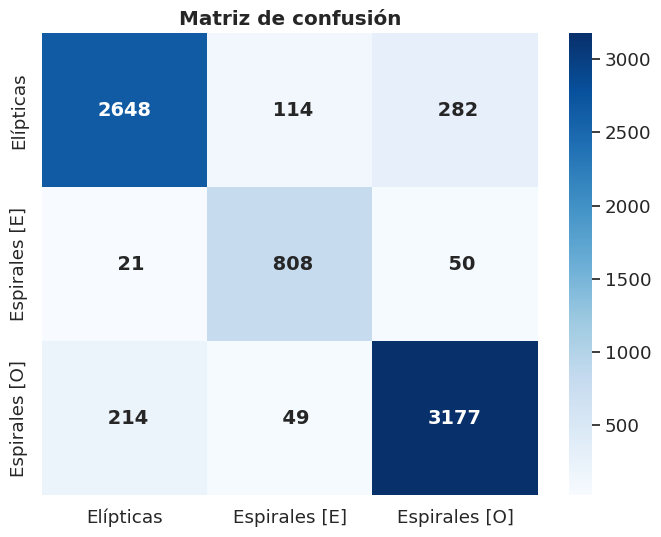

In [289]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='4.0f', xticklabels=['Elípticas', 'Espirales [E]', 'Espirales [O]'], yticklabels=['Elípticas', 'Espirales [E]', 'Espirales [O]'], 
            annot_kws={'fontsize':14,'fontweight':'bold'}, cmap='Blues')
plt.title('Matriz de confusión', weight='bold')

plt.savefig("Model/confusion_matrix.png")

In [206]:
# Curva ROC
fpr, tpr, thr = roc_curve(y_true, y_prob, pos_label=1) # Obtener métricas y threshold
roc_auc = roc_auc_score(y_true, y_prob) # Area bajo la curva de ROC (mayor = mejor)

# Plot curva ROC
sns.set(font_scale=1)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Curva ROC(AUC DINOv2 = %0.2f)' % roc_auc) 

plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio') 
plt.xlabel('False Positive Rate', size=14) 
plt.ylabel('True Positive Rate', size=14) 
plt.title('Curva ROC', size=16, weight='bold') 
plt.legend(loc="lower right") 
plt.show()

plt.savefig('Model/roc_curve.png')

ValueError: multi_class must be in ('ovo', 'ovr')